# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Note that this is a ternary classification problem.

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



## Import packages

In [113]:
import pandas as pd
import numpy as np
import sys
import zipfile
import folium
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from mlxtend.classifier import StackingClassifier

## Data

#### Import Data

In [144]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [145]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

In [146]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [147]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Maps

#### Scatter Plot of Wells

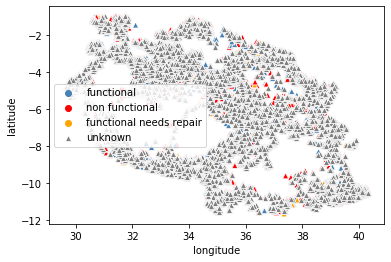

In [6]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]
df_loc.status_group.value_counts()

sns.scatterplot(data=df_loc, x = 'longitude', y = 'latitude', marker = '^', alpha = 1,
                hue = df_loc.status_group.tolist(), palette = ['steelblue', 'red', 'orange'])


test_df_loc = unlabeled_df[['longitude', 'latitude']]
test_df_loc = test_df_loc[test_df_loc['longitude']!=0]
test_df_loc['status_group'] = 'unknown'
sns.scatterplot(data = test_df_loc, x = 'longitude', y = 'latitude', marker= "^", color = 'grey', label = 'unknown');

#### Import shape files for Tanzania

In [7]:
# Uncomment to download shapefiles
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [8]:
# Uncomment to unzip shapefiles
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

#### Create GeoDataFrames from Data
Convert crs from 4326 to 3857 (changes latitude and logitude format for plotting)

In [9]:
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
geo_df = geo_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
# Add a geometry column that holds Point objects with lat and long
df_loc['geometry'] = df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf = gpd.GeoDataFrame(df_loc, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
# Add a geometry column that holds Point objects with lat and long
test_df_loc['geometry'] = test_df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf_test = gpd.GeoDataFrame(test_df_loc, geometry='geometry')
gdf_test.crs = "EPSG:4326"
gdf_test = gdf_test.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Create Folium map to show where Tanzania is

In [12]:
m = folium.Map(location=[-6.3690, 34.8888], zoom_start = 5)
m.choropleth(geo_data=geo_df, fill_color='blue', fill_opacity=0.2, line_opacity=.1)
display(m)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Geopandas plots with Contextly

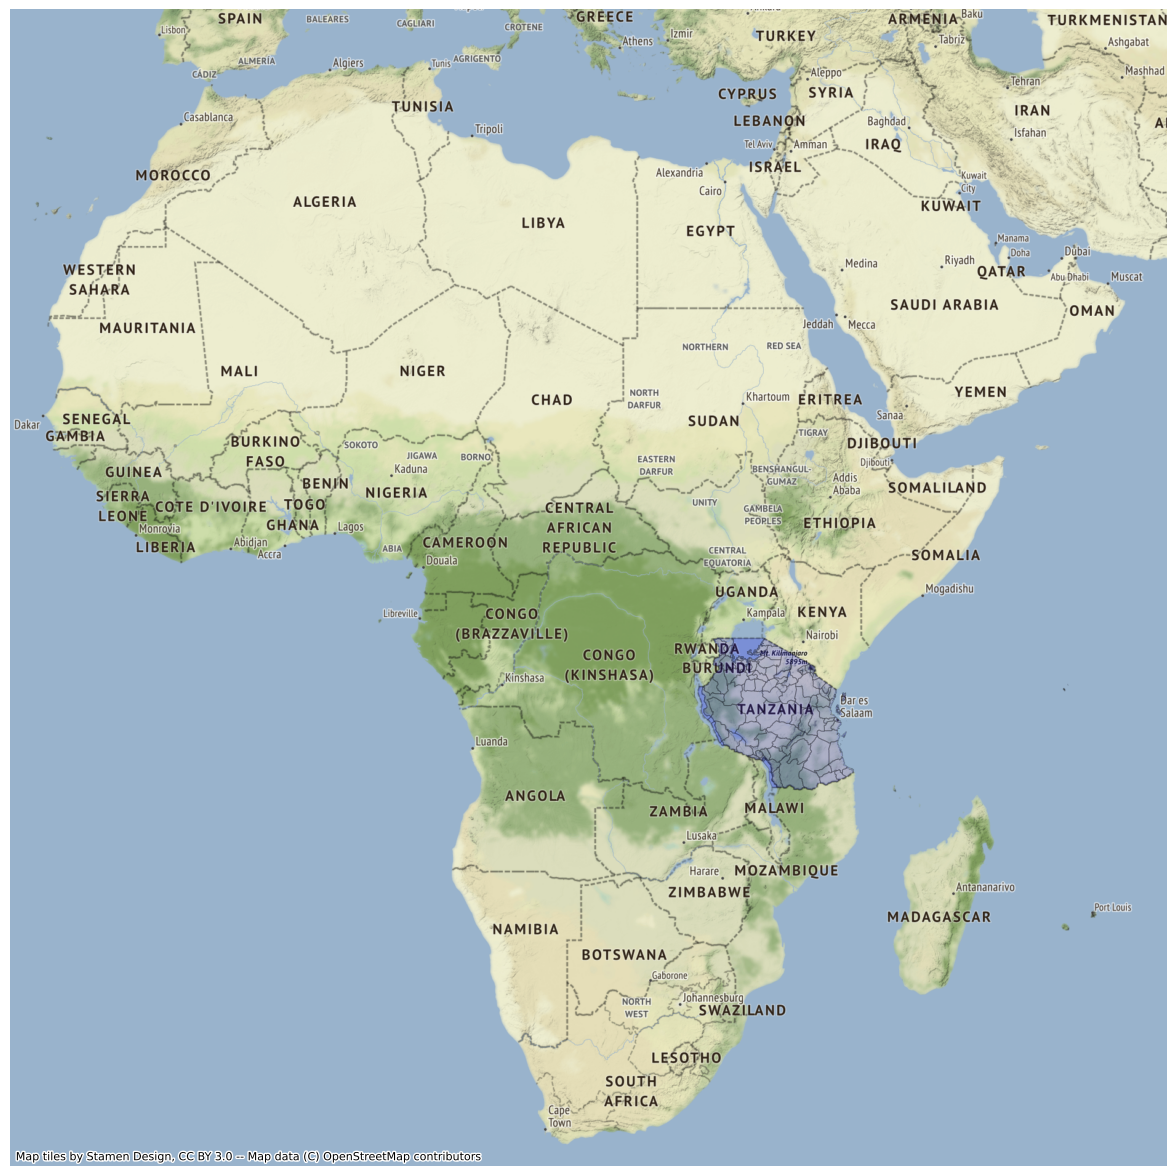

In [13]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .2)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5500000, maxx+2500000)
ax.set_ylim(miny-3000000, maxy+5000000)

ctx.add_basemap(ax, zoom = 5) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzanian Water Wells')

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Africa.jpg');

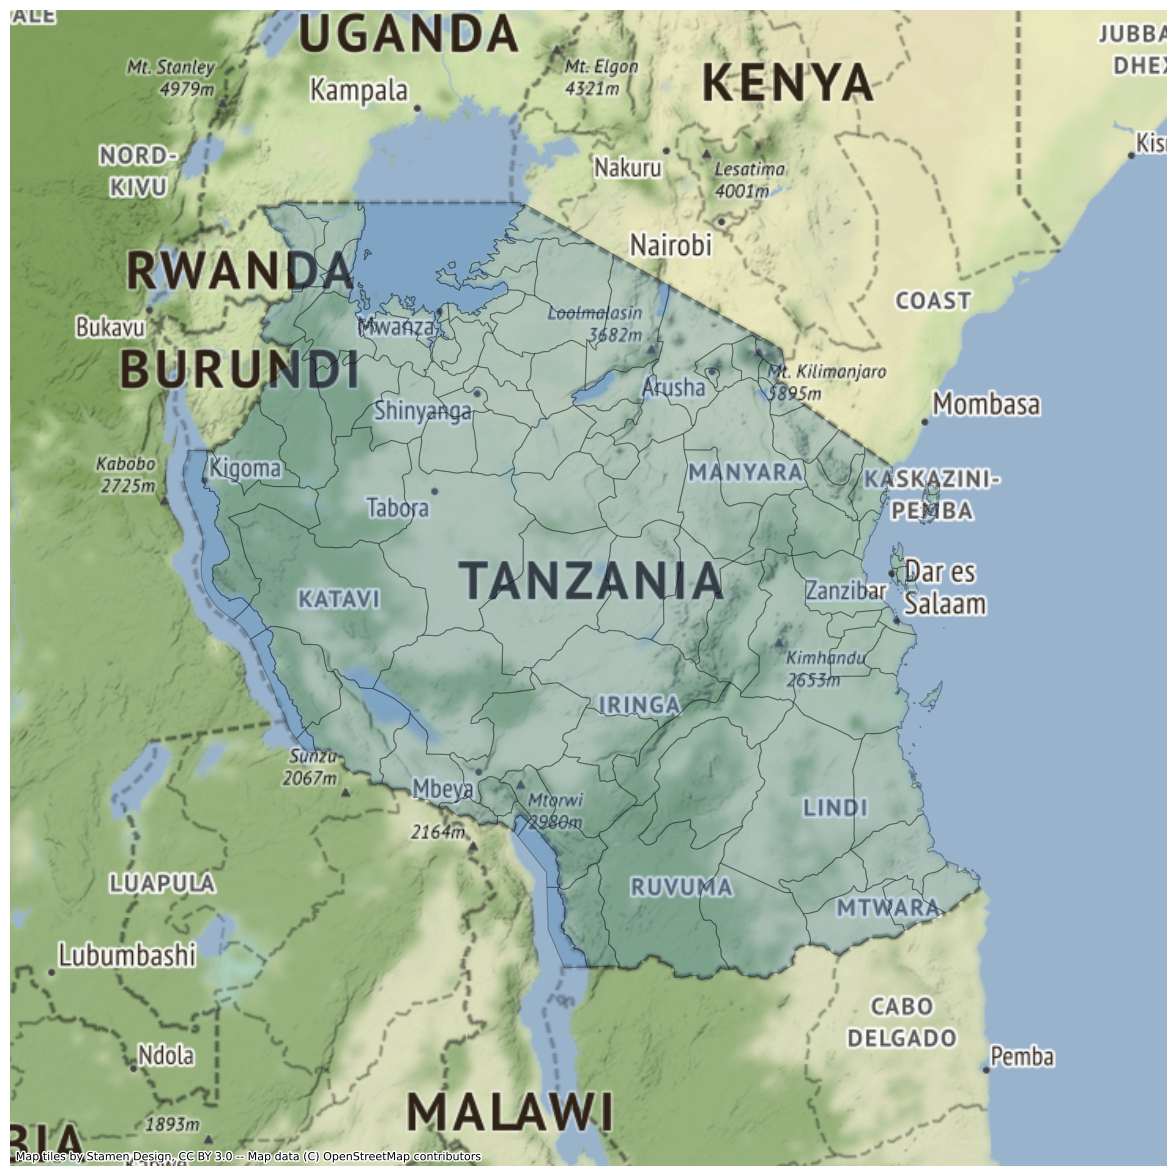

In [14]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .3)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-300000, maxx+300000)
ax.set_ylim(miny-300000, maxy+300000)

ctx.add_basemap(ax) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzania', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania.jpg', dpi = 300);

#### Add Wells + Status to Plot

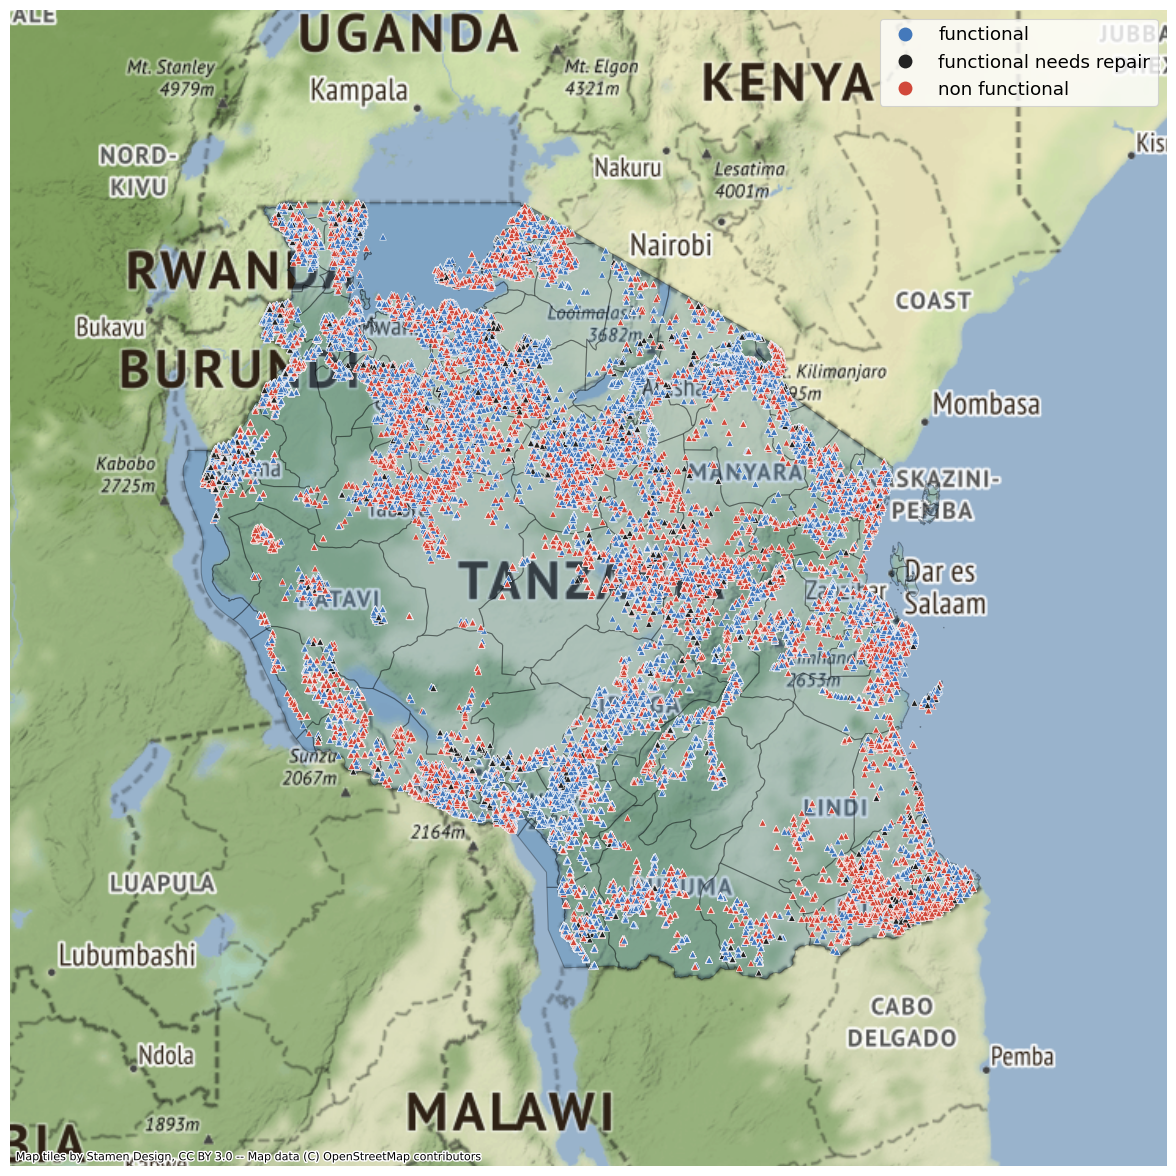

In [15]:
sns.set_context(font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))

geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .3)

custom_palette = sns.diverging_palette(250, 15, l=50, center="dark", as_cmap=True)

gdf.plot(ax=ax, column = 'status_group', marker = '^', 
         edgecolor = 'white', cmap = custom_palette,
         linewidth=0.4, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-300000, maxx+300000)
ax.set_ylim(miny-300000, maxy+300000)

ctx.add_basemap(ax)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_train.jpg', dpi = 300);

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


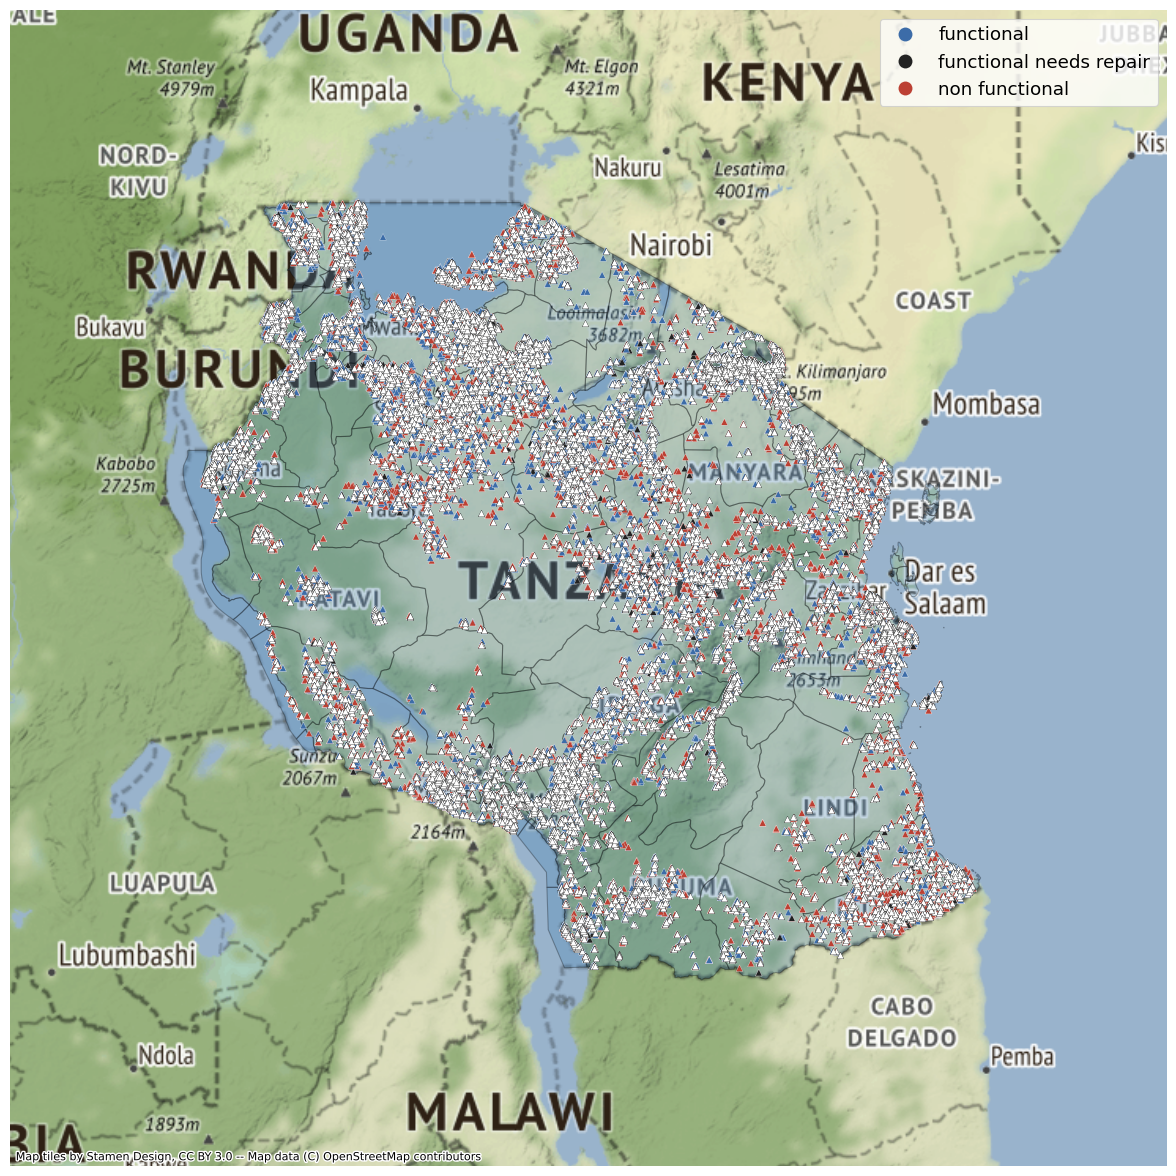

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .3)

custom_palette = sns.diverging_palette(250, 15, l=45, center="dark", as_cmap=True)

gdf.plot(ax=ax, column = 'status_group', marker = '^', 
         edgecolor = 'white', cmap = custom_palette,
         linewidth=0.2, legend = True)

gdf_test.plot(ax=ax, marker = '^', column = 'status_group', color = 'white',
              edgecolor = 'black', linewidth=0.2, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-300000, maxx+300000)
ax.set_ylim(miny-300000, maxy+300000)

ctx.add_basemap(ax)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_test.jpg', dpi = 300);

### Data Cleaning

#### Drop Date and NA and unique identifier columns for now

In [17]:
# X.info()

In [18]:
columns_with_na = ['permit', 'scheme_name', 'scheme_management', 'public_meeting', 'subvillage', 'installer', 'funder']
X.drop(columns_with_na, axis=1, inplace=True)

In [19]:
columns_with_specific_location_and_names = ['ward', 'wpt_name']
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [20]:
X.drop('date_recorded', axis=1, inplace=True)

### EDA Visuals

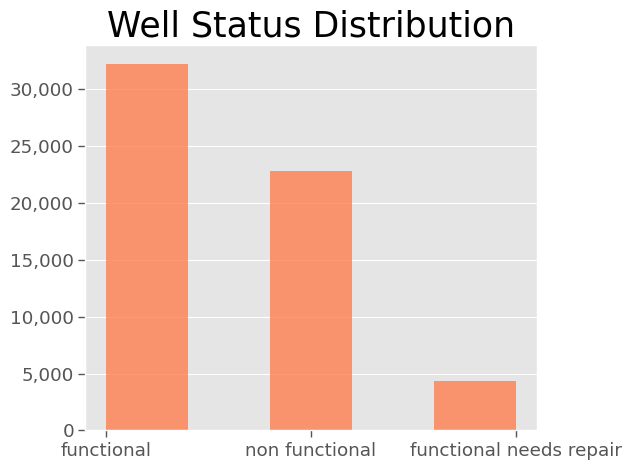

In [21]:
sns.set_context("paper", font_scale=1.5)

plt.style.use('ggplot')

fig, ax = plt.subplots() 
ax.hist(y, alpha = .8, bins = 5, color = 'coral')
ax.set_title('Well Status Distribution', fontdict={'fontsize': '25', 'fontweight' : '30', 'color' : 'black'})
ax.xaxis.grid() # horizontal lines

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

fig.tight_layout()
plt.savefig('../../reports/figures/Well_status_dist.jpg')

## Preprocess Data for Model

#### Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#### Split Data into continuous and categorical

In [23]:
X.dtypes.value_counts()

object     20
int64       6
float64     3
dtype: int64

In [24]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_cont = X_train.select_dtypes(exclude='object')
X_test_cat = X_test.select_dtypes(include='object')
X_test_cont = X_test.select_dtypes(exclude='object')

#### Simple Imputer to fill null numeric values

In [25]:
si = SimpleImputer()
X_train_imp = pd.DataFrame(si.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)
X_test_imp = pd.DataFrame(si.transform(X_test_cont), index = X_test_cont.index, columns = X_test_cont.columns)

#### Standard Scaler to scale numeric values

In [26]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train_imp), index = X_train_imp.index, columns = X_train_imp.columns)
X_test_sc = pd.DataFrame(ss.transform(X_test_imp), index = X_test_imp.index, columns = X_test_imp.columns)

#### OneHotEncoder for categorical columns

In [27]:
# X_train_cat.info()

In [28]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat),
                          columns = ohe.get_feature_names(X_train_cat.columns), index = X_train_cat.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat),
                          columns = ohe.get_feature_names(X_test_cat.columns), index = X_test_cat.index)

#### Join numeric and object DataFrames back together after preprocessing

In [29]:
X_train_fin = X_train_sc.join(X_train_ohe)
X_test_fin = X_test_sc.join(X_test_ohe)
print('Features Count: ', X_train_fin.shape[1])

Features Count:  291


## Modeling

#### Create a Baseline Model

In [30]:
lr = LogisticRegression(max_iter=1000, random_state = 42)
lr.fit(X_train_fin, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Score model on training data

In [31]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print(classification_report(y_train, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81     24161
functional needs repair       0.58      0.12      0.20      3243
         non functional       0.80      0.67      0.72     17146

               accuracy                           0.75     44550
              macro avg       0.70      0.56      0.58     44550
           weighted avg       0.75      0.75      0.73     44550



In [32]:
# Note - This cell takes time to run
# val = cross_val_score(lr, X_train_fin, y_train, cv=5)
# val

#### Score model on testing data

In [33]:
# Score on our testing data
y_pred = lr.predict(X_test_fin)
print(classification_report(y_test, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.78      0.66      0.72      5678

               accuracy                           0.75     14850
              macro avg       0.68      0.56      0.57     14850
           weighted avg       0.74      0.75      0.73     14850



#### Coefficients of Features

In [34]:
coef = pd.DataFrame(lr.coef_, columns = X_test_fin.columns).transpose()

In [35]:
pd.set_option('display.max_rows', 500)
# coef

### Refining our Data

#### Using Smote to Deal with Class Imbalance

In [36]:
y_train.value_counts()

functional                 24161
non functional             17146
functional needs repair     3243
Name: status_group, dtype: int64

In [37]:
print("Before OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train == 'functional needs repair'))) 
print("Before OverSampling, counts of label 'functional': {}".format(sum(y_train == 'functional'))) 
print("Before OverSampling, counts of label 'non functional': {} \n".format(sum(y_train == 'non functional'))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_fin, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train_res == 'functional needs repair'))) 
print("After OverSampling, counts of label 'functional': {}".format(sum(y_train_res == 'functional'))) 
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_train_res == 'non functional')))

Before OverSampling, counts of label 'functional needs repair': 3243
Before OverSampling, counts of label 'functional': 24161
Before OverSampling, counts of label 'non functional': 17146 

After OverSampling, the shape of train_X: (72483, 291)
After OverSampling, the shape of train_y: (72483,) 

After OverSampling, counts of label 'functional needs repair': 24161
After OverSampling, counts of label 'functional': 24161
After OverSampling, counts of label 'non functional': 24161


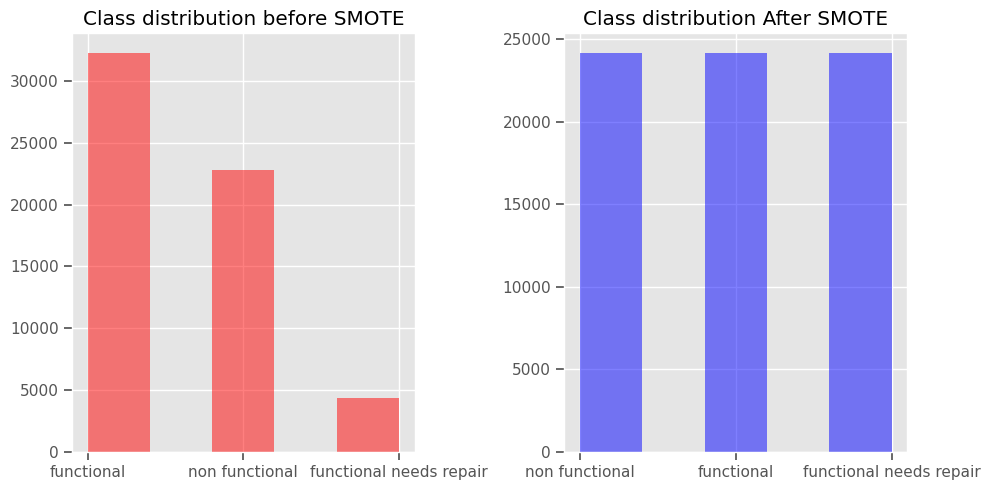

In [38]:
sns.set_context("notebook")
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout();

#### Model After Smote

In [39]:
lr2 = LogisticRegression(max_iter=1000, random_state = 42)
lr2.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
# Score on our training data
y_pred = lr2.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.65     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [41]:
# Score on our testing data
y_pred = lr2.predict(X_test_fin)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.72      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



Our accuracy is now more even across classes, especially on the training data. However on the testing data, while the recall score soared, the precision score plummeted? The f1 score is still not great on the testing data either but really improved on the training data for class "functional needs repair". Considering our model is working much better on our training data than our testing data, we could use regularization techniques to avoid overfitting.

#### Dealing with Multicollinearity
Some investigators use correlation coefficients cutoffs of 0.5 and above but most typical cutoff is 0.80

In [ ]:
# X_train_res, y_train_res, X_test_fin, y_test

In [174]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 3))

Top Absolute Correlations
management_unknown             management_group_unknown               1.0
extraction_type_windmill       extraction_type_class_wind-powered     1.0
extraction_type_gravity        extraction_type_group_gravity          1.0
payment_other                  payment_type_other                     1.0
extraction_type_gravity        extraction_type_class_gravity          1.0
source_dam                     source_type_dam                        1.0
extraction_type_other          extraction_type_class_other            1.0
payment_never pay              payment_type_never pay                 1.0
source_type_other              source_class_unknown                   1.0
waterpoint_type_cattle trough  waterpoint_type_group_cattle trough    1.0
dtype: float64


In [173]:
top_corrs = get_top_abs_correlations(X_train_res, 75) #Threshhold correlation for cut off is .75

In [175]:
features_to_drop = [pair[1] for pair in top_corrs.index]

In [184]:
len(features_to_drop)

75

In [185]:
# Remove Duplicates from list
features_to_drop = list(dict.fromkeys(features_to_drop))
len(features_to_drop)

58

In [187]:
X_train_res.shape

(72483, 291)

In [191]:
X_train_res.drop(features_to_drop, axis=1, inplace=True)

In [192]:
X_train_res.shape

(72483, 233)

In [196]:
X_test_fin.shape

(14850, 291)

In [197]:
X_test_fin.drop(features_to_drop, axis=1, inplace=True)

In [198]:
X_test_fin.shape

(14850, 233)

In [199]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 3))

Top Absolute Correlations
basin_Lake Tanganyika  region_Kigoma         0.735790
longitude              lga_Bariadi           0.734270
water_quality_salty    water_quality_soft    0.727066
dtype: float64


#### Feature Selection

In [200]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train_res,y_train_res)

ExtraTreesClassifier()

In [201]:
# print(model.feature_importances_) 
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_train_res.columns).sort_values(by = 0, ascending = False)
feature_importance_df.head(10)

0
longitude              0.117432
latitude               0.114336
gps_height             0.054229
quantity_dry           0.053580
construction_year      0.043211
population             0.039737
quantity_enough        0.025274
quantity_insufficient  0.019387
extraction_type_other  0.018834
waterpoint_type_other  0.017759

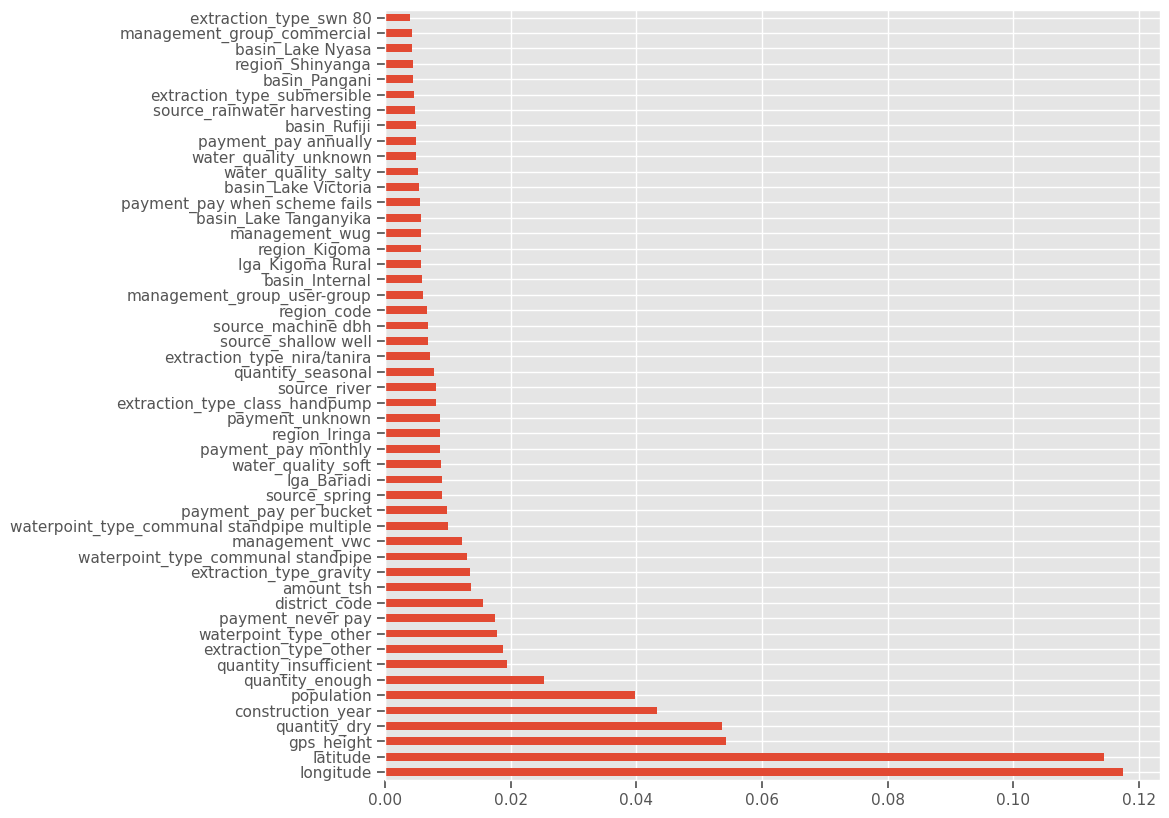

In [202]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_res.columns)
fig = plt.subplots(figsize = (10,10))
feat_importances.nlargest(50).plot(kind='barh')
plt.show();

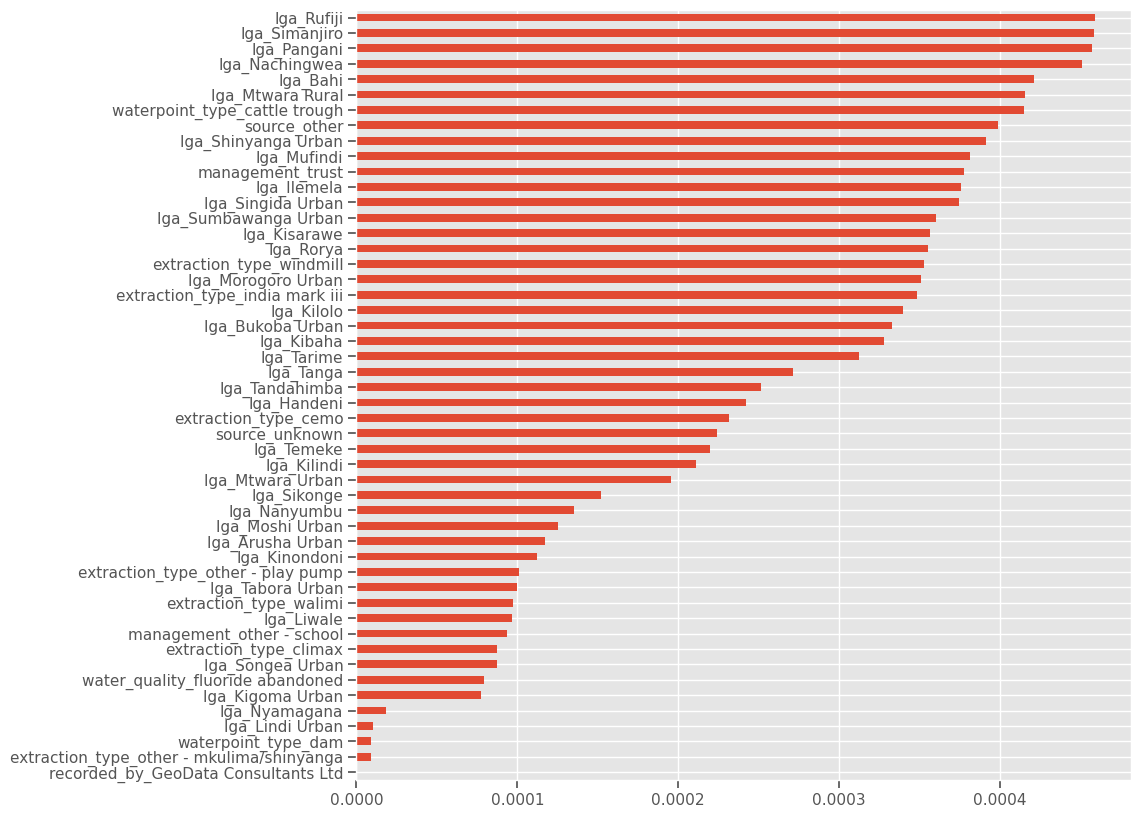

In [203]:
fig = plt.subplots(figsize = (10,10))
feat_importances.nsmallest(50).plot(kind='barh');


#### Filtered feature selection

In [204]:
print('Feature count: ', X_train_res.shape[1])

Feature count:  233


In [205]:
# Filter training and testing data with 233 largest features
X_train_filt = X_train_res[feat_importances.nlargest(233).index]
X_test_filt = X_test_fin[feat_importances.nlargest(233).index]

In [206]:
print('Feature count: ', X_train_filt.shape[1])

Feature count:  233


### Modeling with our Refined Data

Using hyperparameters from Andrew's tuning

In [207]:
# X_train_filt
# y_train_res
# X_test_filt
# y_test

#### Logistic Regression

In [208]:
lr3 = LogisticRegression(C=10, max_iter=1000, tol=10, random_state = 42)
lr3.fit(X_train_filt, y_train_res)

LogisticRegression(C=10, max_iter=1000, random_state=42, tol=10)

In [209]:
# Score on our training data
y_pred = lr3.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [210]:
# Score on our testing data
y_pred = lr3.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.71      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



#### KNN

In [211]:
knn1 = KNeighborsClassifier(n_neighbors = 5, p=1, weights='distance')
knn1.fit(X_train_filt, y_train_res)

KNeighborsClassifier(p=1, weights='distance')

In [212]:
# Score on our training data
y_pred = knn1.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99     24161
functional needs repair       0.99      0.99      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           0.99     72483
              macro avg       0.99      0.99      0.99     72483
           weighted avg       0.99      0.99      0.99     72483



In [213]:
# Score on our testing data
y_pred = knn1.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.77      0.79      8098
functional needs repair       0.34      0.51      0.41      1074
         non functional       0.78      0.76      0.77      5678

               accuracy                           0.75     14850
              macro avg       0.64      0.68      0.66     14850
           weighted avg       0.76      0.75      0.75     14850



#### Decision Tree

In [214]:
dt = DecisionTreeClassifier(max_depth=9, min_samples_split=3, min_samples_leaf =1, random_state=42)
dt.fit(X_train_filt, y_train_res)

DecisionTreeClassifier(max_depth=9, min_samples_split=3, random_state=42)

In [215]:
# Score on our training data
y_pred = dt.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.57      0.72      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.87      0.53      0.66     24161

               accuracy                           0.66     72483
              macro avg       0.70      0.66      0.66     72483
           weighted avg       0.70      0.66      0.66     72483



In [216]:
# Score on our testing data
y_pred = dt.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.69      0.71      8098
functional needs repair       0.19      0.64      0.29      1074
         non functional       0.85      0.51      0.64      5678

               accuracy                           0.62     14850
              macro avg       0.59      0.62      0.55     14850
           weighted avg       0.74      0.62      0.65     14850



#### SVC

In [217]:
# svm = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)
# svm.fit(X_train_filt, y_train_res)

In [218]:
# # Score on our training data
# y_pred = svm.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [219]:
# # Score on our testing data
# y_pred = svm.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

## Ensemble Methods

Voting and Averaging are "weak" estimators. They are useful in the case that the models are already accurate

#### VotingClassifier

In [220]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_voting = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)])

In [221]:
clf_voting.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=9,
                                                     min_samples_split=3,
                                                     random_state=42))])

In [222]:
# Score on our training data
y_pred = clf_voting.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.71      0.84      0.77     24161
functional needs repair       0.79      0.85      0.82     24161
         non functional       0.94      0.70      0.80     24161

               accuracy                           0.80     72483
              macro avg       0.81      0.80      0.80     72483
           weighted avg       0.81      0.80      0.80     72483



In [223]:
# Score on our testing data
y_pred = clf_voting.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.75      0.77      8098
functional needs repair       0.25      0.66      0.36      1074
         non functional       0.85      0.64      0.73      5678

               accuracy                           0.70     14850
              macro avg       0.63      0.68      0.62     14850
           weighted avg       0.77      0.70      0.72     14850



#### Averaging Classifier

In [227]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_averaging = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)],
    voting = 'soft',
)
clf_averaging.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=9,
                                                     min_samples_split=3,
                                                     random_state=42))],
                 voting='soft')

In [228]:
# Score on our training data
y_pred = clf_averaging.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

KeyboardInterrupt: 

In [ ]:
# Score on our testing data
y_pred = clf_averaging.predict(X_test_filt)
print(classification_report(y_test, y_pred))

#### Extra Trees Classifier

In [ ]:
# etc = ExtraTreesClassifier()
# etc.fit(X_train_filt,y_train_res)

In [ ]:
# # Score on our training data
# y_pred = etc.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [ ]:
# # Score on our testing data
# y_pred = etc.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

#### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=2000, random_state=42)
rfc.fit(X_train_filt,y_train_res)

In [ ]:
# Score on our training data
y_pred = rfc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

In [ ]:
# Score on our testing data
y_pred = rfc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

#### Bagging Classifier Random Forest

Note Bagging is computationally expensive as it uses cross validation and will take time to run

For classification, the optimal value of max_features lies around the square root of the number of features. The square root of 250 is 15.8.

In [78]:
# Setting max_features to 35 after some trial and error. The square root of number of features didnt seem to work well
b_rf_clf = BaggingClassifier(RandomForestClassifier(max_depth=26), n_estimators = 30, max_features=35, random_state=42)
b_rf_clf.fit(X_train_filt,y_train_res)

BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=26),
                  max_features=35, n_estimators=30, random_state=42)

In [80]:
# Score on our training data
y_pred = b_rf_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.84      0.84     24161
functional needs repair       0.85      0.93      0.89     24161
         non functional       0.92      0.81      0.86     24161

               accuracy                           0.86     72483
              macro avg       0.86      0.86      0.86     72483
           weighted avg       0.86      0.86      0.86     72483



In [81]:
# Score on our testing data
y_pred = b_rf_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.77      0.79      8098
functional needs repair       0.30      0.60      0.40      1074
         non functional       0.82      0.72      0.76      5678

               accuracy                           0.74     14850
              macro avg       0.64      0.69      0.65     14850
           weighted avg       0.78      0.74      0.75     14850



GridSearch on Bagging Classifier

In [82]:
# grid = {"max_samples": [0.5, 1.0],
#         "bootstrap": [True, False],
#         "bootstrap_features": [True, False]}

# b_rf_clf = GridSearchCV(BaggingClassifier(RandomForestClassifier(max_depth=25), n_estimators = 10, max_features = 35),
#                         param_grid = grid)

Do not run the following cells again, takes a very long time and best params are just the default -_-

In [83]:
# b_rf_clf.fit(X_train_filt,y_train_res)

In [84]:
# b_rf_clf.best_params_
# 'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0

### Boosting Algorithms
Based on iterative learning and sequential model building.
Good choice when problems are complex, need to apply parallel processing, have big data sets

#### Ada Boost Classifier

In [85]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train_filt, y_train_res)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [86]:
# Score on our training data
y_pred = adaboost_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.65      0.65     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.74      0.63      0.69     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [87]:
# Score on our testing data
y_pred = adaboost_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.64      0.71      8098
functional needs repair       0.20      0.64      0.30      1074
         non functional       0.77      0.63      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.58      0.64      0.57     14850
           weighted avg       0.73      0.64      0.67     14850



#### Gradient Boosting Classifier

In [88]:
# Instantiate an GradientBoostingClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_clf.fit(X_train_filt, y_train_res)

GradientBoostingClassifier(random_state=42)

In [89]:
# Score on our training data
y_pred = gbt_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.67      0.74      0.70     24161
functional needs repair       0.72      0.78      0.75     24161
         non functional       0.81      0.65      0.73     24161

               accuracy                           0.72     72483
              macro avg       0.73      0.72      0.72     72483
           weighted avg       0.73      0.72      0.72     72483



In [90]:
# Score on our testing data
y_pred = gbt_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.72      0.75      8098
functional needs repair       0.23      0.61      0.33      1074
         non functional       0.81      0.64      0.71      5678

               accuracy                           0.68     14850
              macro avg       0.61      0.66      0.60     14850
           weighted avg       0.75      0.68      0.71     14850



#### Extreme Gradient Boosting Classifier

Optomized for distributed computing. Parallel training.

In [91]:
xgbc = xgb.XGBClassifier(max_depth=10, random_state=42)
xgbc.fit(X_train_filt,y_train_res)

XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [92]:
# Score on our training data
y_pred = xgbc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.83      0.83     24161
functional needs repair       0.83      0.94      0.88     24161
         non functional       0.91      0.80      0.85     24161

               accuracy                           0.85     72483
              macro avg       0.86      0.85      0.85     72483
           weighted avg       0.86      0.85      0.85     72483



In [93]:
# Score on our testing data
y_pred = xgbc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.30      0.62      0.40      1074
         non functional       0.84      0.73      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.76     14850



#### Light Gradient Boosting

Released by Microsoft in 2017
Fast and efficient. Lighter in terms of space.
Optimized for parallel and GPU processing.
Useful for big datasets.

In [94]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
clf_lgb = lgb.LGBMClassifier(n_estimators=1000, seed=42)
clf_lgb.fit(X_train_filt,y_train_res)

LGBMClassifier(n_estimators=1000, seed=42)

In [95]:
# Score on our training data
y_pred = clf_lgb.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.90      0.90      0.90     24161
functional needs repair       0.92      0.96      0.94     24161
         non functional       0.95      0.90      0.92     24161

               accuracy                           0.92     72483
              macro avg       0.92      0.92      0.92     72483
           weighted avg       0.92      0.92      0.92     72483



In [96]:
# Score on our testing data
y_pred = clf_lgb.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.82      0.82      8098
functional needs repair       0.38      0.53      0.44      1074
         non functional       0.82      0.77      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.71      0.69     14850
           weighted avg       0.79      0.78      0.78     14850



#### Cat Boost
Open sourced by Yandex(april 2017). Built in handling of categorical features. Accurate and robust. Fast and scalable

In [110]:
# Default Params - n_estimators=1000, learning_rate=0.1, max_depth=3, 
reg_cat = cb.CatBoostClassifier(random_state=500)
reg_cat.fit(X_train_filt, y_train_res)

Learning rate set to 0.098445
0:	learn: 1.0608063	total: 74.8ms	remaining: 1m 14s
1:	learn: 1.0304541	total: 151ms	remaining: 1m 15s
2:	learn: 1.0057773	total: 234ms	remaining: 1m 17s
3:	learn: 0.9853847	total: 310ms	remaining: 1m 17s
4:	learn: 0.9683969	total: 387ms	remaining: 1m 17s
5:	learn: 0.9533494	total: 467ms	remaining: 1m 17s
6:	learn: 0.9401962	total: 546ms	remaining: 1m 17s
7:	learn: 0.9291913	total: 618ms	remaining: 1m 16s
8:	learn: 0.9181327	total: 704ms	remaining: 1m 17s
9:	learn: 0.9095233	total: 779ms	remaining: 1m 17s
10:	learn: 0.9006674	total: 862ms	remaining: 1m 17s
11:	learn: 0.8920994	total: 940ms	remaining: 1m 17s
12:	learn: 0.8840070	total: 1.01s	remaining: 1m 16s
13:	learn: 0.8774964	total: 1.09s	remaining: 1m 16s
14:	learn: 0.8707570	total: 1.17s	remaining: 1m 16s
15:	learn: 0.8645928	total: 1.25s	remaining: 1m 16s
16:	learn: 0.8588557	total: 1.33s	remaining: 1m 16s
17:	learn: 0.8507432	total: 1.41s	remaining: 1m 17s
18:	learn: 0.8457790	total: 1.49s	remaining

160:	learn: 0.6288598	total: 12.6s	remaining: 1m 5s
161:	learn: 0.6283506	total: 12.7s	remaining: 1m 5s
162:	learn: 0.6278591	total: 12.8s	remaining: 1m 5s
163:	learn: 0.6271483	total: 12.8s	remaining: 1m 5s
164:	learn: 0.6265888	total: 12.9s	remaining: 1m 5s
165:	learn: 0.6258061	total: 13s	remaining: 1m 5s
166:	learn: 0.6250035	total: 13.1s	remaining: 1m 5s
167:	learn: 0.6246361	total: 13.1s	remaining: 1m 5s
168:	learn: 0.6241442	total: 13.2s	remaining: 1m 4s
169:	learn: 0.6233667	total: 13.3s	remaining: 1m 4s
170:	learn: 0.6227530	total: 13.3s	remaining: 1m 4s
171:	learn: 0.6219504	total: 13.4s	remaining: 1m 4s
172:	learn: 0.6215094	total: 13.5s	remaining: 1m 4s
173:	learn: 0.6207918	total: 13.6s	remaining: 1m 4s
174:	learn: 0.6203044	total: 13.6s	remaining: 1m 4s
175:	learn: 0.6193966	total: 13.7s	remaining: 1m 4s
176:	learn: 0.6190118	total: 13.8s	remaining: 1m 4s
177:	learn: 0.6181973	total: 13.9s	remaining: 1m 3s
178:	learn: 0.6178213	total: 13.9s	remaining: 1m 3s
179:	learn: 0.

322:	learn: 0.5507681	total: 24.8s	remaining: 52.1s
323:	learn: 0.5505726	total: 24.9s	remaining: 52s
324:	learn: 0.5502586	total: 25s	remaining: 51.9s
325:	learn: 0.5499916	total: 25.1s	remaining: 51.8s
326:	learn: 0.5496158	total: 25.1s	remaining: 51.7s
327:	learn: 0.5493135	total: 25.2s	remaining: 51.7s
328:	learn: 0.5489543	total: 25.3s	remaining: 51.6s
329:	learn: 0.5486525	total: 25.4s	remaining: 51.5s
330:	learn: 0.5481464	total: 25.4s	remaining: 51.4s
331:	learn: 0.5477920	total: 25.5s	remaining: 51.3s
332:	learn: 0.5475316	total: 25.6s	remaining: 51.2s
333:	learn: 0.5470338	total: 25.7s	remaining: 51.2s
334:	learn: 0.5466794	total: 25.7s	remaining: 51.1s
335:	learn: 0.5463818	total: 25.8s	remaining: 51s
336:	learn: 0.5459064	total: 25.9s	remaining: 50.9s
337:	learn: 0.5455513	total: 25.9s	remaining: 50.8s
338:	learn: 0.5453241	total: 26s	remaining: 50.7s
339:	learn: 0.5450137	total: 26.1s	remaining: 50.7s
340:	learn: 0.5447943	total: 26.2s	remaining: 50.6s
341:	learn: 0.544329

483:	learn: 0.5077631	total: 37.1s	remaining: 39.6s
484:	learn: 0.5076148	total: 37.2s	remaining: 39.5s
485:	learn: 0.5073711	total: 37.3s	remaining: 39.4s
486:	learn: 0.5072406	total: 37.4s	remaining: 39.4s
487:	learn: 0.5070575	total: 37.4s	remaining: 39.3s
488:	learn: 0.5068836	total: 37.5s	remaining: 39.2s
489:	learn: 0.5067758	total: 37.6s	remaining: 39.1s
490:	learn: 0.5066345	total: 37.7s	remaining: 39.1s
491:	learn: 0.5063573	total: 37.8s	remaining: 39s
492:	learn: 0.5061967	total: 37.8s	remaining: 38.9s
493:	learn: 0.5060221	total: 37.9s	remaining: 38.8s
494:	learn: 0.5058189	total: 38s	remaining: 38.8s
495:	learn: 0.5056412	total: 38.1s	remaining: 38.7s
496:	learn: 0.5053455	total: 38.2s	remaining: 38.6s
497:	learn: 0.5049624	total: 38.3s	remaining: 38.6s
498:	learn: 0.5047106	total: 38.3s	remaining: 38.5s
499:	learn: 0.5045107	total: 38.4s	remaining: 38.4s
500:	learn: 0.5043487	total: 38.5s	remaining: 38.3s
501:	learn: 0.5040583	total: 38.6s	remaining: 38.3s
502:	learn: 0.50

642:	learn: 0.4783790	total: 49.3s	remaining: 27.4s
643:	learn: 0.4782392	total: 49.4s	remaining: 27.3s
644:	learn: 0.4780788	total: 49.4s	remaining: 27.2s
645:	learn: 0.4779831	total: 49.5s	remaining: 27.1s
646:	learn: 0.4779112	total: 49.6s	remaining: 27s
647:	learn: 0.4778092	total: 49.6s	remaining: 27s
648:	learn: 0.4775932	total: 49.7s	remaining: 26.9s
649:	learn: 0.4774404	total: 49.8s	remaining: 26.8s
650:	learn: 0.4772452	total: 49.9s	remaining: 26.7s
651:	learn: 0.4770788	total: 50s	remaining: 26.7s
652:	learn: 0.4768910	total: 50s	remaining: 26.6s
653:	learn: 0.4767685	total: 50.1s	remaining: 26.5s
654:	learn: 0.4765485	total: 50.2s	remaining: 26.4s
655:	learn: 0.4764276	total: 50.3s	remaining: 26.4s
656:	learn: 0.4761530	total: 50.4s	remaining: 26.3s
657:	learn: 0.4760006	total: 50.4s	remaining: 26.2s
658:	learn: 0.4757780	total: 50.5s	remaining: 26.1s
659:	learn: 0.4755752	total: 50.6s	remaining: 26.1s
660:	learn: 0.4754183	total: 50.7s	remaining: 26s
661:	learn: 0.4752700	

802:	learn: 0.4560601	total: 1m 1s	remaining: 15.1s
803:	learn: 0.4559115	total: 1m 1s	remaining: 15s
804:	learn: 0.4557842	total: 1m 1s	remaining: 15s
805:	learn: 0.4556309	total: 1m 1s	remaining: 14.9s
806:	learn: 0.4555215	total: 1m 1s	remaining: 14.8s
807:	learn: 0.4553875	total: 1m 1s	remaining: 14.7s
808:	learn: 0.4553082	total: 1m 2s	remaining: 14.7s
809:	learn: 0.4551697	total: 1m 2s	remaining: 14.6s
810:	learn: 0.4550353	total: 1m 2s	remaining: 14.5s
811:	learn: 0.4548987	total: 1m 2s	remaining: 14.4s
812:	learn: 0.4547942	total: 1m 2s	remaining: 14.3s
813:	learn: 0.4546765	total: 1m 2s	remaining: 14.3s
814:	learn: 0.4545999	total: 1m 2s	remaining: 14.2s
815:	learn: 0.4544521	total: 1m 2s	remaining: 14.1s
816:	learn: 0.4543491	total: 1m 2s	remaining: 14s
817:	learn: 0.4542121	total: 1m 2s	remaining: 14s
818:	learn: 0.4541140	total: 1m 2s	remaining: 13.9s
819:	learn: 0.4540285	total: 1m 2s	remaining: 13.8s
820:	learn: 0.4539380	total: 1m 2s	remaining: 13.7s
821:	learn: 0.453823

960:	learn: 0.4386852	total: 1m 13s	remaining: 2.99s
961:	learn: 0.4385731	total: 1m 13s	remaining: 2.92s
962:	learn: 0.4384644	total: 1m 13s	remaining: 2.84s
963:	learn: 0.4383307	total: 1m 13s	remaining: 2.76s
964:	learn: 0.4382659	total: 1m 14s	remaining: 2.68s
965:	learn: 0.4381806	total: 1m 14s	remaining: 2.61s
966:	learn: 0.4381160	total: 1m 14s	remaining: 2.53s
967:	learn: 0.4380183	total: 1m 14s	remaining: 2.45s
968:	learn: 0.4379077	total: 1m 14s	remaining: 2.38s
969:	learn: 0.4378016	total: 1m 14s	remaining: 2.3s
970:	learn: 0.4376963	total: 1m 14s	remaining: 2.22s
971:	learn: 0.4376588	total: 1m 14s	remaining: 2.15s
972:	learn: 0.4375514	total: 1m 14s	remaining: 2.07s
973:	learn: 0.4374854	total: 1m 14s	remaining: 1.99s
974:	learn: 0.4374125	total: 1m 14s	remaining: 1.92s
975:	learn: 0.4373351	total: 1m 14s	remaining: 1.84s
976:	learn: 0.4372111	total: 1m 14s	remaining: 1.76s
977:	learn: 0.4370887	total: 1m 15s	remaining: 1.69s
978:	learn: 0.4369707	total: 1m 15s	remaining: 

In [111]:
# Score on our training data
y_pred = reg_cat.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.81      0.81     24161
functional needs repair       0.84      0.91      0.87     24161
         non functional       0.88      0.79      0.83     24161

               accuracy                           0.84     72483
              macro avg       0.84      0.84      0.84     72483
           weighted avg       0.84      0.84      0.84     72483



In [112]:
# Score on our testing data
y_pred = reg_cat.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.32      0.59      0.41      1074
         non functional       0.82      0.75      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.71      0.67     14850
           weighted avg       0.79      0.76      0.77     14850



### Stacking

Combining models together. Good choice when Voting/Averaging dont have great results

In [102]:
# Parameters = classifiers = [clf1, clf2, clf3...], meta_classifiers=clf_meta, use_probas=False, use_features_in_secondary=False

clf_dt = DecisionTreeClassifier(random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_lr = LogisticRegression(max_iter=1000, random_state=42)

classifiers = [clf_dt, clf_knn, clf_lr]

clf_meta = DecisionTreeClassifier(random_state=42)

clf_stack = StackingClassifier(classifiers, clf_meta, use_features_in_secondary=True)

Target classes need to be numerical for StackingClassifier to work. Use Label Encoder for this

In [118]:
le = LabelEncoder()
le.fit(y_train_res)

LabelEncoder()

In [125]:
y_train_le = le.fit_transform(y_train_res)
y_test_le = le.transform(y_test)

In [126]:
clf_stack.fit(X_train_filt, y_train_le)

StackingClassifier(classifiers=[DecisionTreeClassifier(random_state=42),
                                KNeighborsClassifier(),
                                LogisticRegression(max_iter=1000,
                                                   random_state=42)],
                   meta_classifier=DecisionTreeClassifier(random_state=42),
                   use_features_in_secondary=True)

In [127]:
# Score on our training data
y_pred = clf_stack.predict(X_train_filt)
print(classification_report(y_train_le, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24161
           1       0.99      1.00      0.99     24161
           2       1.00      1.00      1.00     24161

    accuracy                           1.00     72483
   macro avg       1.00      1.00      1.00     72483
weighted avg       1.00      1.00      1.00     72483



In [128]:
# Score on our testing data
y_pred = clf_stack.predict(X_test_filt)
print(classification_report(y_test_le, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      8098
           1       0.34      0.47      0.40      1074
           2       0.76      0.75      0.76      5678

    accuracy                           0.74     14850
   macro avg       0.63      0.66      0.65     14850
weighted avg       0.75      0.74      0.75     14850



#### Where to go from here

removing features with high collinearity

those columns with the null values

Looks like we still have some overfitting so think of reducing features

tuning hyper parameters